# The Hybrid Model

Version Control:
- Last Trial
- 8 CA counties
- Averaged on 5 runs

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_lattice as tfl
import time

In [2]:
# import data
df = pd.read_csv("CACases.csv", index_col = False)
df.reset_index(drop=True, inplace=True)
df.head()

,date,Los Angeles,San Diego,San Francisco,Santa Barbara,Fresno,Sacramento,Ventura,Riverside
0,2020-02-01,13.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,2020-02-02,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-02-03,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2020-02-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# counties we are interested in
counties = ["Los Angeles", "San Diego", "San Francisco", "Santa Barbara",\
            "Fresno", "Sacramento", "Ventura", "Riverside"]

# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [4]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# for each county
df1 = df.copy()  # deep copy
df1 = df1.iloc[6:]
for county in counties:
    # holder
    temp = []
    # take average, starting from 7th day
    for i in range(6,len(df)):
        # remove day of week effect
        ave = np.mean(df[county].iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
        temp.append(ave)
    df1[county] = temp

In [5]:
df1.set_index("date", inplace=True)

In [6]:
# input: original dataset, county we want
# output: all data, sorted by date, of that county
def extract(dataset, county):
    # select data only from the input county
    temp = dataset.to_dict()[county]
    temp = pd.Series(temp)
    # reset index
    # temp.reset_index(drop=True, inplace=True)
    return temp

# Data Preprocessing
## Differencing
- Differencing of time series in discrete time
- transformation of series to a new time series wehre values are the difference between consecutive values of previous series
- help stablizing the mean of time series by removing trend

In [7]:
# create a differenced series, output as Series
# interval: order of differencing, default = 1
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        # no need to difference
        if (interval == 0):
            value = dataset[i]
        else:
            value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
# input: single original, single prediction, interval(default as 1)
def invert_difference(history, yhat, interval=1):
    if (interval == 0):
        return yhat
    else:
        return yhat + history

## Scaling
- Scale the data to [-1,1]

In [8]:
# scale train and test data to [-1, 1]
# input: train(np array, train_size*1), test(np array, test_size*1)
def scale(train, test):
    # find scalers
    aveTrain = np.mean(train)
    maxTrain = max(train)
    minTrain = min(train)
    scaler = [aveTrain, maxTrain, minTrain]
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = (train - aveTrain)/(maxTrain-minTrain)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = (test - aveTrain)/(maxTrain-minTrain)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value
# input: scaler, single prediction yhat
def invert_scale(scaler, yhat):
    inverted = yhat*(scaler[1]-scaler[2]) + scaler[0]
    return inverted[0][0]  # output: a number

## Reshaping

In [9]:
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# transform series into train and test sets for supervised learning
def prepare_data(series, diff, train_size, test_size, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # differencing
    diff_series = difference(raw_values, diff)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # split into train & test
    train_diff, test_diff = diff_values[:(train_size-diff)], diff_values[(train_size-diff):]
    # rescaling
    scaler, train_scaled, test_scaled = scale(train_diff, test_diff)
    # adjust data type for train_scaled, test_scaled
    train_scaled = [row[0][0] for row in train_scaled]
    test_scaled = [row[0][0] for row in test_scaled]
    # convert to supervised
    train = series_to_supervised(train_scaled, n_lag, n_seq).values
    test = series_to_supervised(test_scaled, n_lag, n_seq).values
    return scaler, train, test  # scaler: list of np array, train: np array, test: np array

# Long Short-Term Memory(LSTM)
- The Long Short-Term Memory network or LSTM is a recurrent neural network that can learn and forecast long sequences.
- Walk forward model validation: a prediction will be made for a time step, then the real value used for model to predict next time step
    - stimulates the reality
- RMSE will be used: punishes large errors and results in a score that is in the same units as the forecast data

In [10]:
def fit_comb(train, n_lag, n_seq, n_batch, n_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    Z = X.reshape(X.shape[0], 1, X.shape[1])
    # AR layer
    input1 = tf.keras.layers.Input(shape=(X.shape[1],))
    AR = tfl.layers.Linear(num_input_dims=X.shape[1], units=n_seq)(input1)
    # lstm layer
    input2 = tf.keras.layers.Input(shape=(Z.shape[1],Z.shape[2]))
    lstm = layers.LSTM(n_seq)(input2)
    # combine
    added = tf.keras.layers.add([AR, lstm])
    out = tf.keras.layers.Dense(n_seq)(added)
    model = tf.keras.models.Model(inputs=[input1,input2], outputs=out)
    # compile before training or testing
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(n_epoch):
        model.fit([X, Z], y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Prediction and Evaluation

In [11]:
# make one forecast with a hybird model
def forecast_comb(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    Z = X.reshape(1, 1, len(X))
    X = X.reshape(1, len(X))
    # make forecast
    forecast = model.predict([X,Z], batch_size=n_batch)
    return [x for x in forecast[0, :]][0]
    return [x for x in forecast[0, :]][0]
# evaluate the model
def make_forecasts(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)
    for i in range(len(test)):
        X = test[i, 0:n_lag]
        # make forecast
        forecast = forecast_comb(model, X, n_batch)
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [12]:
# evaluate forcasts
def evaluate_forecasts(actual, forecasts):
    rmse = np.sqrt(mean_squared_error(actual, forecasts))
    mae = mean_absolute_error(actual, forecasts)
    mape = mean_absolute_percentage_error(actual, forecasts)*100
    return rmse, mae, mape

## A Single Trial as Demo

In [13]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_batch = 1
nb_epoch = 100
n_neurons = 1

In [14]:
county = "Los Angeles"

In [15]:
# prepare data
s = extract(df1, county)
raw_value = s[-(train_size+test_size+n_lag):]
scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)

In [16]:
raw_value = s[-(train_size+test_size+n_lag):]
raw_value

2022-06-10    4483.571429
2022-06-11    4458.000000
2022-06-12    4442.285714
2022-06-13    4282.142857
2022-06-14    4128.714286
                 ...     
2022-09-01    1748.571429
2022-09-02    1608.714286
2022-09-03    1470.285714
2022-09-04    1311.714286
2022-09-05     946.000000
Length: 88, dtype: float64

In [17]:
# make forecasts
forecasts = make_forecasts(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
evaluate_forecasts(raw_value[-test_size:], forecasts)

(74.58492135111452, 54.61031793701753, 3.543172459020258)

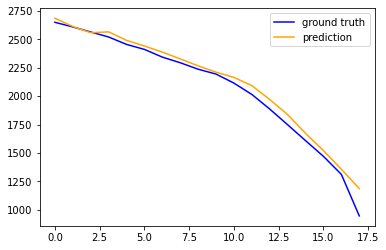

In [18]:
truth = raw_value[-test_size:].to_list()
plt.plot(truth, color = 'blue', label = "ground truth")
plt.plot(forecasts, color = 'orange', label = "prediction")
plt.legend()
plt.savefig("comb_demo.png", dpi=600)

# Evaluate LSTM Method on All Counties

In [19]:
# for each date t
    # use [t, t + train_size) as training set
    # use [t + train_size, t + train_size + test_size) as testing set
    # evaluate by calculating RMSE

# holder for metrics:
RMSE = []
MAE = []
MAPE = []
trainingTime = []
for county in counties:
    # cut a data trial from original dataset
    # prepare data
    s = extract(df1, county)
    raw_value = s[-(train_size+test_size+n_lag):]
    scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)
    # for each dataset, fit model 5 time, take average    
    rmse, mae, mape, training_time = 0, 0, 0, 0
    for i in range(5):
        tic = time.perf_counter()
        model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
        toc = time.perf_counter()
        # make forecasts
        forecasts = make_forecasts(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
        temp = evaluate_forecasts(raw_value[-test_size:], forecasts)
        rmse += temp[0]
        mae += temp[1]
        mape += temp[2]
        training_time += (toc - tic)
    RMSE.append(rmse/5)
    MAE.append(mae/5)
    MAPE.append(mape/5)
    trainingTime.append(training_time/5)

In [20]:
Hybrid_evaluate = {'county': counties, 'rmse': RMSE, 'mae': MAE, 'mape': MAPE, "training time": trainingTime}
Hybrid_evaluate = pd.DataFrame(Hybrid_evaluate)
Hybrid_evaluate

,county,rmse,mae,mape,training time
0,Los Angeles,71.199080,48.676731,3.249719,15.889470
1,San Diego,24.054506,15.658275,3.493302,14.928890
2,San Francisco,5.398897,3.835630,3.967490,14.732026
3,Santa Barbara,4.319714,2.863664,4.087025,16.541464
4,Fresno,7.459437,4.651550,2.893591,16.856812
5,Sacramento,12.030466,7.092764,3.752989,14.872025
6,Ventura,6.019643,3.832741,3.320205,15.383927
7,Riverside,17.159565,11.208413,3.021557,12.815695
